# **Workshop: Tracing Disease Spread Using Genetic and Epidemiological Data**

## **Overview**
In this workshop, students will play the role of molecular epidemiologists investigating an outbreak in a high school. They will use epidemiological data and genetic similarities (pairwise genetic distances) to infer how the disease spread.

## **Learning Objectives**
- Understand how epidemiologists use case information and genetic data to track disease transmission.
- Learn the concept of genetic distances and how they help determine relatedness between infections.
- Develop critical thinking skills by reconstructing a transmission chain.

## **Activity Structure**
1. **Introduction (15 minutes)**
   - Briefly explain how diseases spread and the role of molecular epidemiology.
   - Introduce the concept of genetic distance (i.e., how mutations accumulate as a pathogen spreads).
   - Explain how to interpret a genetic distance matrix.

2. **Solving the Outbreak (40 minutes)**
   - Present the **Case Information Table** and **Genetic Distance Matrix**.
   - Students work in small groups to analyze the data and infer transmission chains.
   - Encourage discussion on uncertainties and alternate explanations.

3. **Discussion and Wrap-Up (20 minutes)**
   - Groups present their findings.
   - Discuss the real-world challenges of outbreak investigations.
   - Highlight key takeaways about combining genetic and epidemiological data.

---

# **Scenario: Outbreak in a High School**

An infectious disease has spread in a high school. Molecular epidemiologists have collected samples from infected students and analyzed their genetic similarities. Your task is to determine who likely infected whom using the available data.


## **Case Information Table**

| Case ID | Symptom Onset Date | Known Contacts | Recent Travel | Sample ID |
|---------|--------------------|---------------|--------------|-----------|
| Alice   | March 2           | Bob, Carol    | No           | S1        |
| Bob     | March 4           | Alice, David  | No           | S2        |
| Carol   | March 6           | Alice, Eve    | No           | S3        |
| David   | March 7           | Bob, Eve      | Yes (London) | S4        |
| Eve     | March 9           | Carol, David  | No           | S5        |

## **Genetic Distance Matrix**

|       | S1 | S2 | S3 | S4 | S5 |
|-------|----|----|----|----|----|
| **S1** | 0  | 1  | 2  | 3  | 3  |
| **S2** | 1  | 0  | 1  | 2  | 3  |
| **S3** | 2  | 1  | 0  | 1  | 2  |
| **S4** | 3  | 2  | 1  | 0  | 1  |
| **S5** | 3  | 3  | 2  | 1  | 0  |

---

## **Student Task**
Using the case information and genetic distance matrix:
1. Identify the most likely **index case** (first infected person).
2. Determine who infected whom.
3. Explain your reasoning using both epidemiological clues (e.g., symptom onset dates, known contacts) and genetic distances.

**Bonus Discussion Questions:**
- What are some challenges of using only genetic distances to infer transmission?
- How might missing cases affect our conclusions?
- What additional data would help confirm the outbreak source?

---

## **Materials Needed**
- Printed handouts with case information and genetic distances.
- Whiteboard or flipchart for group discussions.
- (Optional) Colored markers or sticky notes for mapping transmission chains.

## **Wrap-Up**
Conclude by discussing how real-world outbreak investigations work and how molecular epidemiology informs public health responses.

---

This Markdown version is ready for copying and pasting into any document or platform that supports Markdown formatting.

Here’s your workshop outline formatted in Markdown:

# **High-School Epidemiology Workshop: Tracing Disease Spread**

---

## **1. Introduction to Outbreaks and Disease Dynamics (10 minutes)**

### **What is an Outbreak?**
- Definition and how it differs from:
  - **Endemic**: Constant presence of a disease in a population (e.g., malaria in some regions).
  - **Epidemic**: Sudden increase in cases in a specific area (e.g., seasonal flu spikes).
  - **Pandemic**: Worldwide spread of a new disease (e.g., COVID-19).
- **Real-World Examples**: Seasonal flu vs. COVID-19.

### **How are Outbreaks Flagged?**
- Identifying unusual case clusters or spikes above expected levels.
- Importance of **early detection** in preventing larger outbreaks.

---

## **2. Analyzing Epidemiological Data (15 minutes)**

### **Case Data Overview**
- Present synthetic data including:
  - Case ID
  - Location
  - Symptom onset date

### **Key Questions for Epidemiologists**
- What areas are **high-risk**? (Mapping cases by location)
- What is **driving disease spread**? (Movement patterns, social behavior)
- What is the **mode of transmission**?
  - **Zoonotic**: Animal-to-human transmission (e.g., rabies).
  - **Direct person-to-person**: Human-to-human (e.g., flu, COVID-19).

---

## **3. Establishing Person-to-Person Transmission (15 minutes)**

### **Evidence of Transmission**
- **Symptom Onset Dates**: Analyze timing patterns between cases.
- **Geographic Clustering**: Are cases linked by proximity?

### **Contact Tracing Basics**
- **Goal**: Identify who infected whom by tracking interactions.
- **Challenges in Contact Tracing**:
  - Labor-intensive and costly.
  - Not all contacts lead to transmission.
  - Asymptomatic carriers and under-reporting.

---

## **4. Pathogen Genomic Data and Transmission Links (20 minutes)**

### **Why Use Genomic Data?**
- Provides evidence when contact data is incomplete.
- Helps identify **likely transmission pairs** by comparing genetic similarity.

### **Using Symptom Onset to Infer Direction**
- Combine **genomic data** with **symptom onset dates** to trace who likely infected whom.
- Example: If Case A's symptom onset is earlier than Case B and their genomes are similar, A likely infected B.

---

## **5. Key Epidemiological Concepts (15 minutes)**

- **Generation Time**: Time between successive cases in a chain of transmission.
- **Incubation Period**: Time from **exposure** to **symptom onset**.
- **Latent Period**: Time from **exposure** to **becoming infectious**.
- **Mutation Rate**: How quickly a pathogen's genetic code changes over time.
- **Transmission Rate (R₀)**: Average number of people an infected person transmits the disease to.

---

## **6. Interactive Activity (20 minutes)**

### **Analyze a Simulated Outbreak**
Using the provided synthetic dataset:
1. Identify **high-risk areas**.
2. Determine the **mode of transmission** (zoonotic vs. person-to-person).
3. Trace **possible transmission chains** using:
   - Symptom onset dates.
   - Genomic similarity.

### **Discussion Questions**
- What uncertainties remain in the outbreak investigation?
- What additional data would help improve our understanding?
- What are the challenges of combining **epidemiological** and **genomic** data?

---

Would you like assistance creating **data sheets**, **guiding questions**, or **interactive visual aids**?

Let me know if you want any additional sections or further refinements!

In [210]:
from datetime import timedelta
import sciris as sc
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import random
import needleman_wunsch

sns.set_style("white")
sns.set_context("talk")

```python
param_dict = {
    "r0": 1.5,
    "k": 0.75,
    "seed_infections": 1,
    "total_infections": 26,
    "gen_length": 1000,  # Didn't use actual genome length 29903 to reduce computational time
    "prop_sampled": 1,
    "sampling_delay": 0.0,
}

para_name = "sampling_delay"
param_range = [0.0, 0.1]

simulations = run_simulations(param_dict, para_name, param_range, use_parallel=True)
sc.save("/Users/ydnkka/Desktop/Repositories/PESC-Activity/outbreaks.obj", simulations)
```

In [2]:
simulations = sc.load("outbreaks.obj")
outbreak = simulations[0]

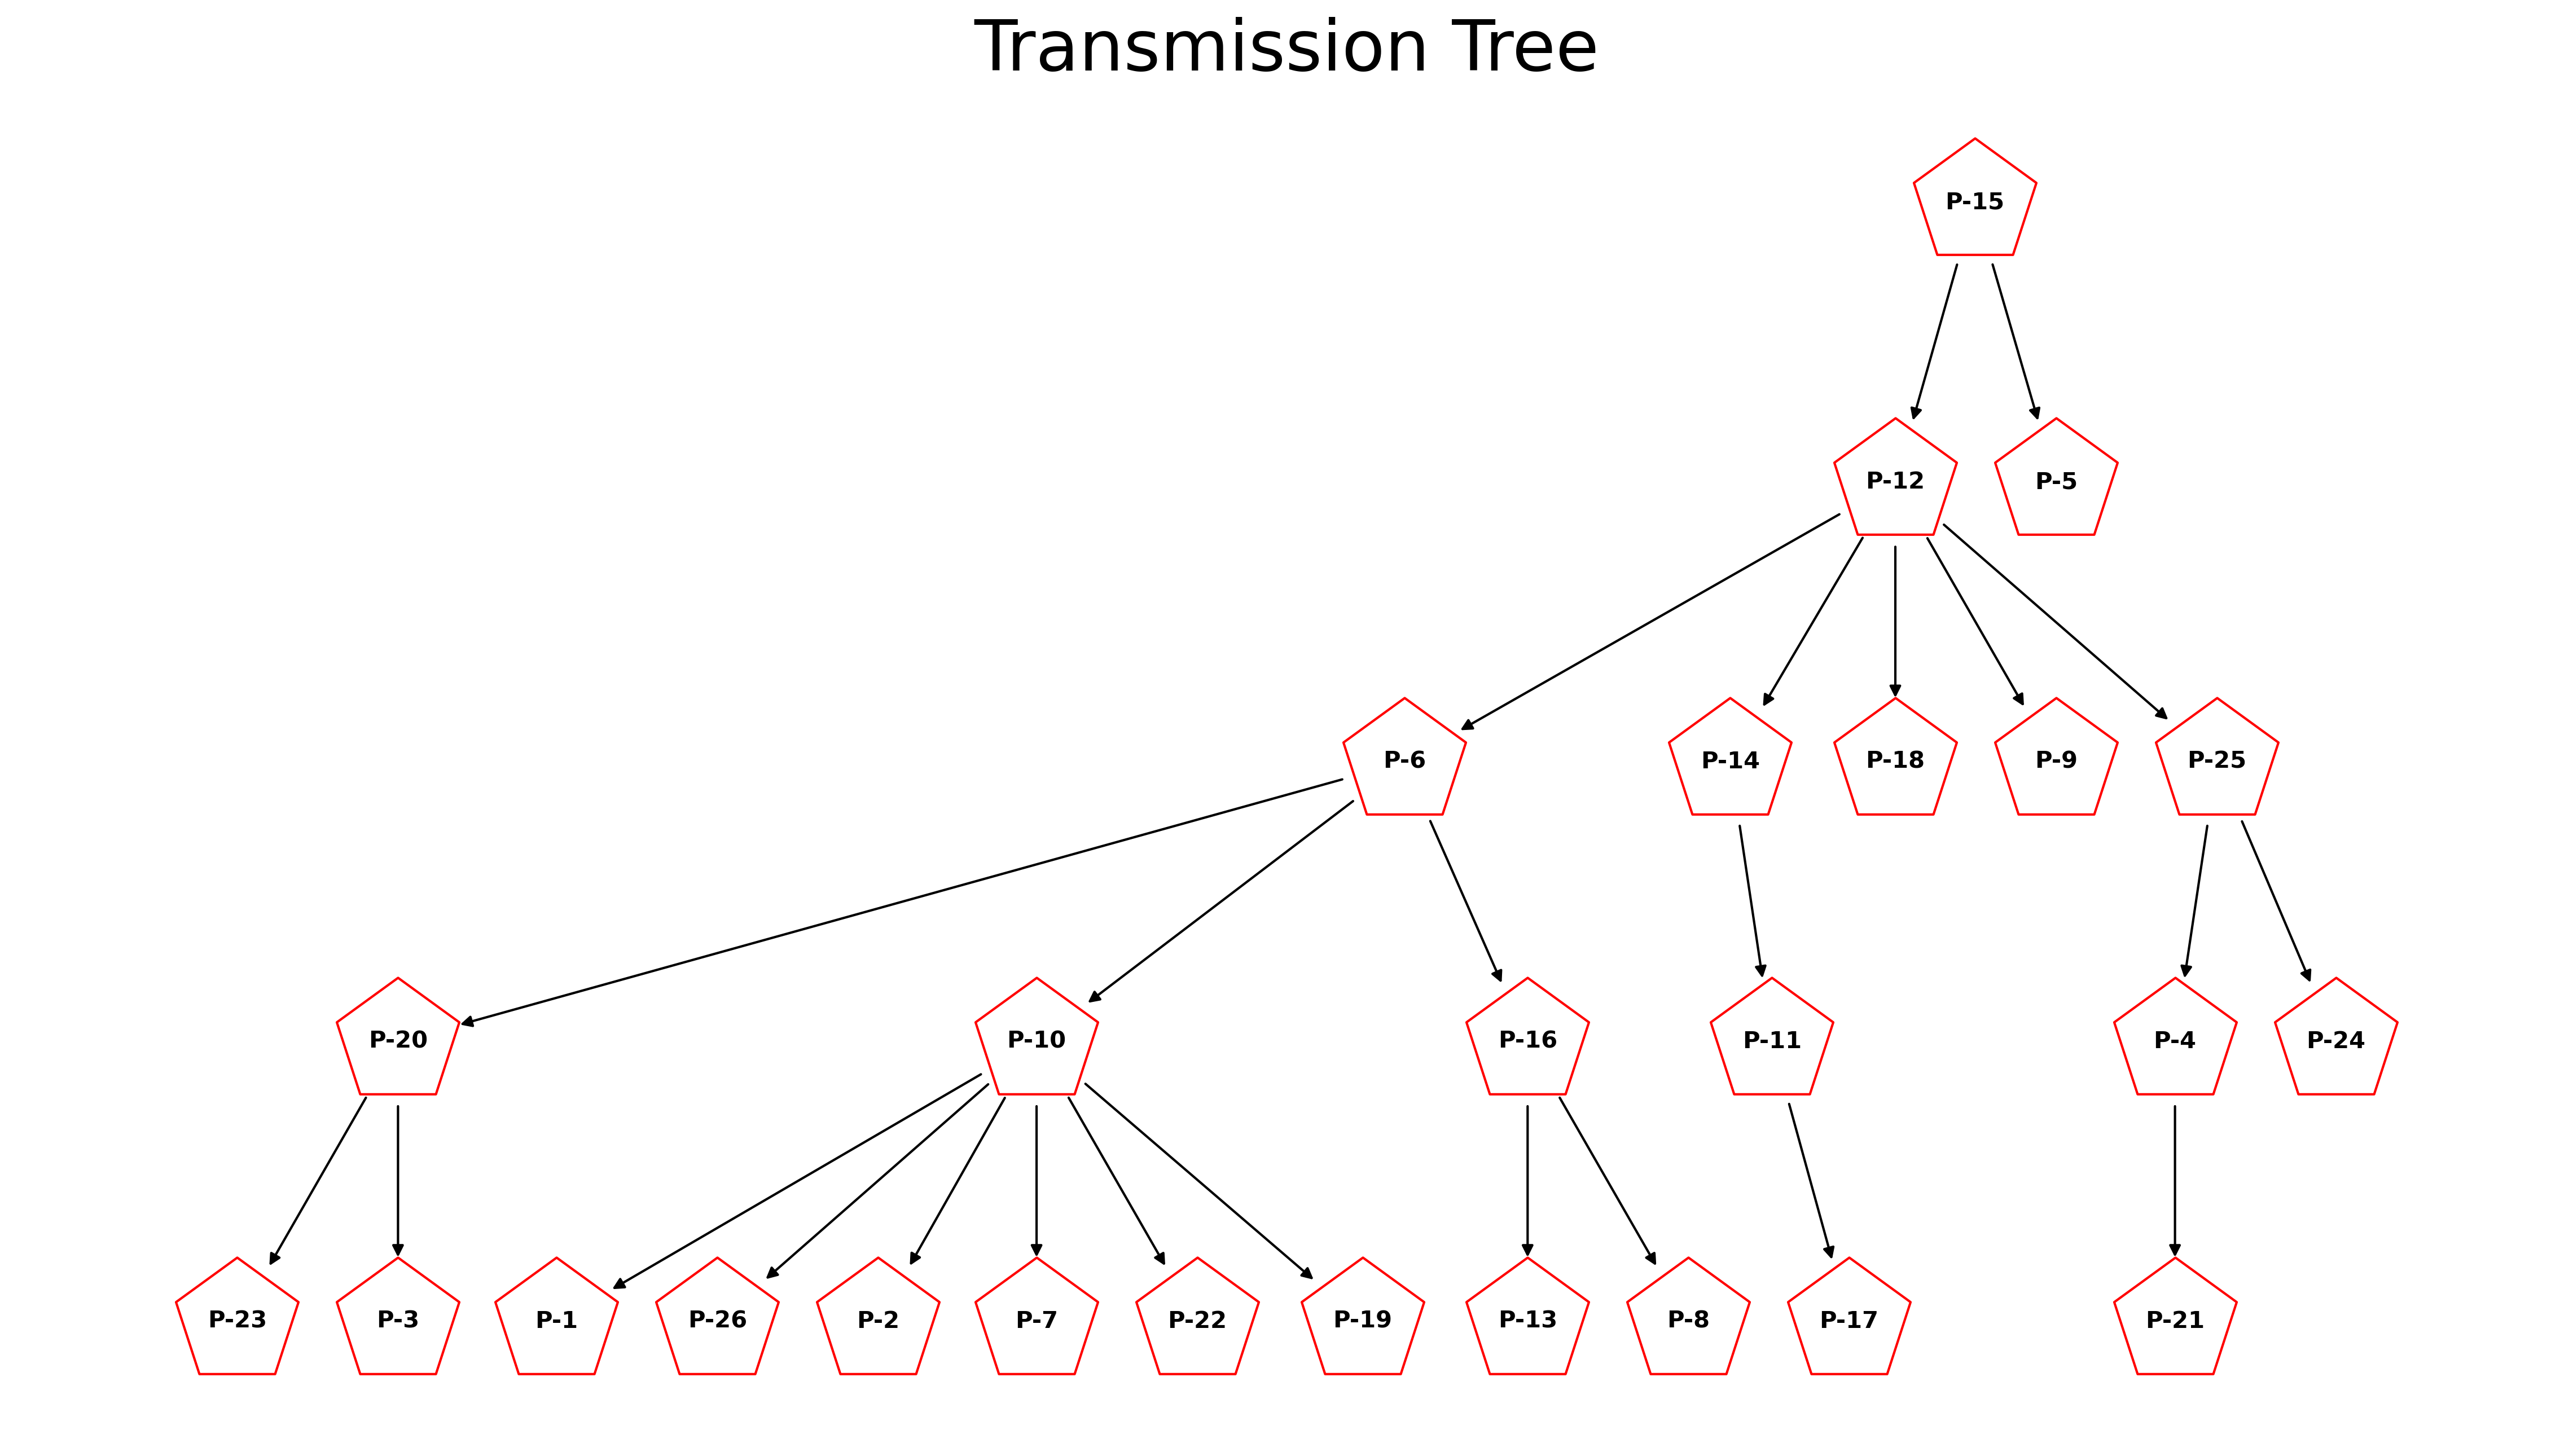

In [3]:
tree = outbreak.tree
original_nodes = list(tree.nodes())
case_names = [f"P-{i}" for i in range(1, len(original_nodes)+1)]
np.random.shuffle(case_names)
node_name_mapping = {original_nodes[i]: case_names[i] for i in range(len(original_nodes))}
tree = nx.relabel_nodes(tree, node_name_mapping)

pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
aspect_ratio = 1.414
fig_size = (15, 8)
plt.figure(figsize=fig_size, dpi=300)  # Increase the figure size
nx.draw(tree, pos,
        with_labels=True,
        width=1,
        edge_color='black',
        node_size=3000,
        font_color='black',
        font_size=10,
        font_weight='bold',
        node_color='white',
        edgecolors='red',
        node_shape='p')

plt.title("Transmission Tree", fontsize=30)
plt.savefig("transmission_tree.png", dpi=300, bbox_inches='tight')
plt.show()

In [4]:
plt.figure(figsize=fig_size, dpi=300)
nx.draw(tree, pos,
        with_labels=False,
        edge_color='black',
        width=1,
        node_size=2000,
        font_size=10,
        font_weight='bold',
        node_color='white',
        edgecolors='red',
        node_shape='p')

node_labels = {n: "?" for n in tree.nodes}
nx.draw_networkx_labels(tree, pos, labels=node_labels, font_weight='bold')

plt.title("Transmission Tree", fontsize=30)
plt.savefig("transmission_tree_question_mark.png", dpi=300, bbox_inches='tight')
plt.close()
# plt.show()

In [5]:
plt.figure(figsize=fig_size, dpi=300)
nx.draw(tree, pos,
        with_labels=False,
        edge_color='black',
        width=1,
        node_size=2000,
        font_size=10,
        font_weight='bold',
        node_color='white',
        edgecolors='red',
        node_shape='p',
        hide_ticks=False)

plt.title("Transmission Tree", fontsize=30)
plt.savefig("transmission_tree_blank.png", dpi=300, bbox_inches='tight')
plt.close()
# plt.show()

In [248]:
transmission_data = nx.to_pandas_edgelist(tree)
transmission_data = transmission_data[["source", "target"]].copy()
transmission_data.rename(columns={"source": "Infector", "target": "Infectee"}, inplace=True)

transmission_data.to_csv("transmission_data.csv", index=False)

transmission_data.head()

,Infector,Infectee
0,P-15,P-12
1,P-15,P-5
2,P-12,P-6
3,P-12,P-14
4,P-12,P-18


In [246]:
transmission_data_student = transmission_data.copy()
transmission_data_student["Infector"] = ""
transmission_data_student["Infectee"] = ""

transmission_data_student.to_csv("transmission_data_student.csv", index=False)

In [178]:
pd.DataFrame(dict(tree.nodes)).T["sample_date"] - pd.DataFrame(dict(tree.nodes)).T["exp_date"]

P-15    5.505036
P-12    5.505036
P-5     5.505036
P-6     5.505036
P-14    5.505036
P-18    5.505036
P-9     5.505036
P-25    5.505036
P-20    5.505036
P-10    5.505036
P-16    5.505036
P-11    5.505036
P-4     5.505036
P-24    5.505036
P-23    5.505036
P-3     5.505036
P-1     5.505036
P-26    5.505036
P-2     5.505036
P-7     5.505036
P-22    5.505036
P-19    5.505036
P-13    5.505036
P-8     5.505036
P-17    5.505036
P-21    5.505036
dtype: object

In [202]:
cases = pd.DataFrame(dict(tree.nodes)).T
cases = cases[["sample_date", "exp_date"]].copy().astype(int)

cases.reset_index(inplace=True, names=["Patient ID"])
cases.rename(columns={"exp_date": "Exposure Date", "sample_date": "Testing Date"}, inplace=True)

cases.sort_values("Exposure Date", inplace=True)

start_date = pd.Timestamp("2020-01-01")
cases["Exposure Date"] = cases["Exposure Date"].apply(lambda x: start_date + timedelta(days=x - 1))
cases["Exposure Date"] = cases["Exposure Date"].dt.strftime('%b-%d')

cases["Testing Date"] = cases["Testing Date"].apply(lambda x: start_date + timedelta(days=x - 1))
cases["Testing Date"] = cases["Testing Date"].dt.strftime('%b-%d')


# Assign locations (siblings and transmission pairs tend to share)
location_variation = 0.5  # Probability of assigning a different location
locations = {}
available_locations = [f"DZ-{i}" for i in range(20)]
assigned_locations = {}

for node in tree.nodes:
    if node == transmission_data.iloc[0, 0]:
        assigned_locations[node] = random.choice(available_locations)  # Root gets a random location
    else:
        parent = list(tree.predecessors(node))[0]
        if random.random() < location_variation:  # Occasionally assign a different location
            assigned_locations[node] = random.choice(available_locations)
        else:
            assigned_locations[node] = assigned_locations[parent]  # Inherit parent's location

# Simulate known contacts (infected and non-infected)
known_contacts = {}
all_nodes = set(tree.nodes)

for node in tree.nodes:
    known_contacts[node] = set(tree.successors(node))  # Direct children are known contacts
    # Add random extra contacts (infected or not)
    possible_contacts = list(all_nodes - {node} - known_contacts[node])
    extra_contacts = random.sample(possible_contacts, min(2, len(possible_contacts)))
    known_contacts[node].update(extra_contacts)

# Add random non-infected contacts
extra_contact_names = [f"C-{i}" for i in range(50, 99)]
non_infected_contacts = {cont: random.choice(available_locations) for cont in extra_contact_names}
for node in known_contacts:
    extra = random.sample(list(non_infected_contacts.keys()), min(2, len(non_infected_contacts)))
    known_contacts[node].update(extra)

In [203]:
locations = pd.DataFrame(assigned_locations.items(), columns=["Patient ID", "Data Zone"])
contacts_list = [(k, list(v)) for k, v in known_contacts.items()]
contacts = pd.DataFrame(contacts_list, columns=["Patient ID", "Known Contact"])
cases = cases.merge(locations, on="Patient ID")
cases = cases.merge(contacts, on="Patient ID")
non_infected_contacts = pd.DataFrame(non_infected_contacts.items(), columns=["Contact ID", "Data-Zone"])


In [197]:
cases.head()

,Patient ID,Testing Date,Exposure Date,Data Zone,Known Contact
0,P-15,Jan-18,Jan-13,DZ-12,"[P-5, C-71, C-97, P-12, P-3, P-14]"
1,P-12,Jan-21,Jan-16,DZ-12,"[P-5, P-25, C-92, P-15, C-76, P-9, P-6, P-18, ..."
2,P-5,Jan-21,Jan-16,DZ-14,"[C-65, P-21, C-97, P-19]"
3,P-6,Jan-24,Jan-19,DZ-17,"[P-25, P-26, P-20, P-16, P-10, C-67, C-60]"
4,P-14,Jan-24,Jan-19,DZ-12,"[C-56, P-23, P-11, P-6, C-94]"


In [206]:
cases.to_csv("master_cases.csv", index=False)
cases[["Patient ID", "Testing Date", "Data Zone"]].to_csv("cases_for_students_1.csv", index=False)
contacts.to_csv("known_contacts_for_students.csv", index=False)
non_infected_contacts.to_csv("non_infected_contacts_for_students.csv", index=False)

In [209]:
cases_student = cases[["Patient ID", "Testing Date", "Data Zone"]].copy()
cases_student["Exposure Date"] = ""
cases_student.to_csv("cases_for_students_2.csv", index=False)

In [208]:
cases_student.head()

,Patient ID,Testing Date,Data Zone,Exposure Data
0,P-15,Jan-18,DZ-18,
1,P-12,Jan-21,DZ-1,
2,P-5,Jan-21,DZ-18,
3,P-6,Jan-24,DZ-17,
4,P-14,Jan-24,DZ-1,


In [243]:
def get_distance_matrix(sequences):
    keys = list(sequences.keys())
    matrix = np.array(list(sequences.values()))

    # Convert nucleotide sequences to numerical values for Hamming distance calculation
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    seq_matrix_num = np.vectorize(mapping.get)(matrix)
    distances = pdist(seq_matrix_num, metric='hamming')  # Proportion of differing sites
    return squareform(distances), keys, matrix


sequences_dict = outbreak.result.linearSeqSim
shuffled_keys = list(sequences_dict.keys())
random.shuffle(shuffled_keys)
shuffled_sequences_dict = {key: sequences_dict[key] for key in shuffled_keys}
hamming_distances, ids, seq_matrix = get_distance_matrix(shuffled_sequences_dict)
hamming_matrix = hamming_distances * seq_matrix.shape[1]  # convert to number of differing positions
hamming_matrix = hamming_matrix.astype(int)

ids = [node_name_mapping[x] for x in ids]
pairwise_distances = pd.DataFrame(hamming_matrix, index=ids, columns=ids)

pairwise_distances.columns.name = "Patient ID"
pairwise_distances.index.name = "Patient ID"

pairwise_distances.to_csv("pairwise_distances.csv")

pairwise_distances.iloc[: 10, :10]

Patient ID,P-4,P-8,P-18,P-23,P-9,P-2,P-21,P-12,P-20,P-3
Patient ID,,,,,,,,,,
P-4,0,5,3,5,3,5,1,2,4,5
P-8,5,0,4,4,4,4,6,3,3,4
P-18,3,4,0,4,2,4,4,1,3,4
P-23,5,4,4,0,4,4,6,3,1,2
P-9,3,4,2,4,0,4,4,1,3,4
P-2,5,4,4,4,4,0,6,3,3,4
P-21,1,6,4,6,4,6,0,3,5,6
P-12,2,3,1,3,1,3,3,0,2,3
P-20,4,3,3,1,3,3,5,2,0,1


In [81]:
def generate_irregular_grid(rows, cols, noise_level=0.3):
    """
    Generate an irregular grid of towns.

    :param rows: Number of rows in the grid
    :param cols: Number of columns in the grid
    :param noise_level: Amount of irregularity in grid lines
    :return: Grid vertices
    """
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Initialize grid points
    grid = np.zeros((rows + 1, cols + 1, 2))

    # Create base grid
    for r in range(rows + 1):
        for c in range(cols + 1):
            # Base coordinates
            x = c
            y = r

            # Add noise to make lines irregular
            x += random.uniform(-noise_level, noise_level)
            y += random.uniform(-noise_level, noise_level)

            grid[r, c] = [x, y]

    return grid

def create_DZ_boundaries(town_names, town_values=None, colormap='YlOrRd', filename="data_zone_boundaries.png"):
    # Determine grid size based on number of towns
    rows = int(np.ceil(np.sqrt(len(town_names))))
    cols = int(np.ceil(len(town_names) / rows))

    # Generate irregular grid
    grid = generate_irregular_grid(rows, cols)

    # Create plot
    plt.figure(figsize=(12, 10), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')

    # Prepare colormap
    if town_values:
        # Normalize values for color mapping
        values = list(town_values.values())
        norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
        scalar_map = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(colormap))

    # Draw grid cells as towns
    town_index = 0
    for r in range(rows):
        for c in range(cols):
            # Skip if we've used all town names
            if town_index >= len(town_names):
                break

            # Get the four corners of this cell
            cell_points = [
                grid[r, c],
                grid[r, c+1],
                grid[r+1, c+1],
                grid[r+1, c]
            ]

            # Determine fill color
            fill_color = 'white'
            if town_values and town_names[town_index] in town_values:
                fill_color = scalar_map.to_rgba(town_values[town_names[town_index]])

            # Create polygon for the cell
            polygon = plt.Polygon(cell_points,
                                  facecolor=fill_color,
                                  edgecolor='black',
                                  linewidth=1)  # Slight transparency
            ax.add_patch(polygon)

            # Add town name
            centroid = np.mean(cell_points, axis=0)
            plt.text(centroid[0], centroid[1],
                     town_names[town_index],
                     ha='center',
                     va='center',
                     fontsize=10,
                     fontweight='bold',
                     )

            town_index += 1

    # Add colorbar if values provided
    if town_values:
        plt.colorbar(scalar_map,
                     label='Number of Cases',
                     ax=ax,
                     shrink=0.8)

    # Set plot limits with some padding
    plt.xlim(-0.5, cols + 0.5)
    plt.ylim(-0.5, rows + 0.5)

    # Remove ticks
    plt.xticks([])
    plt.yticks([])

    plt.title("Map of Data Zones", fontsize=25)

    # Save the plot
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

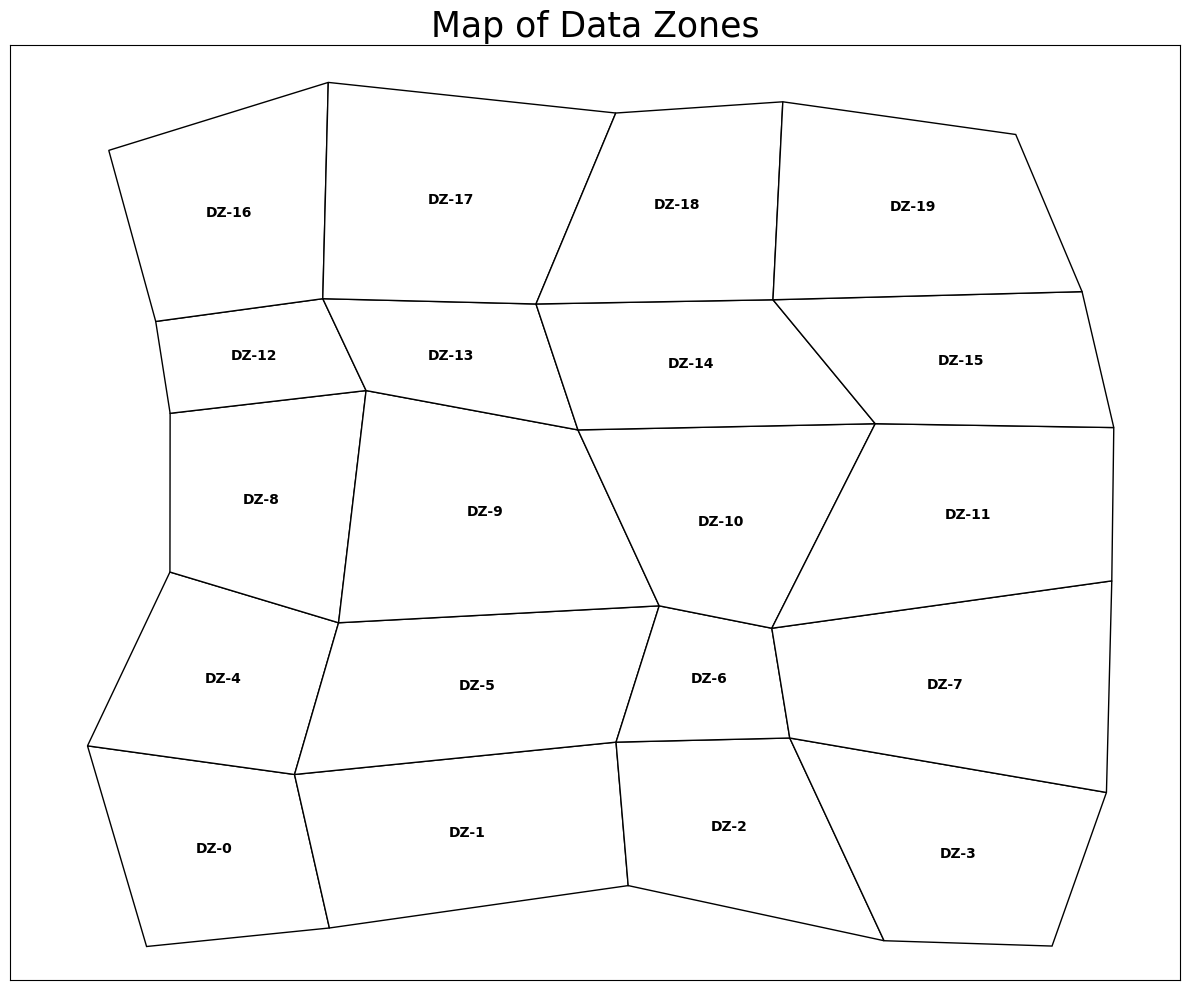

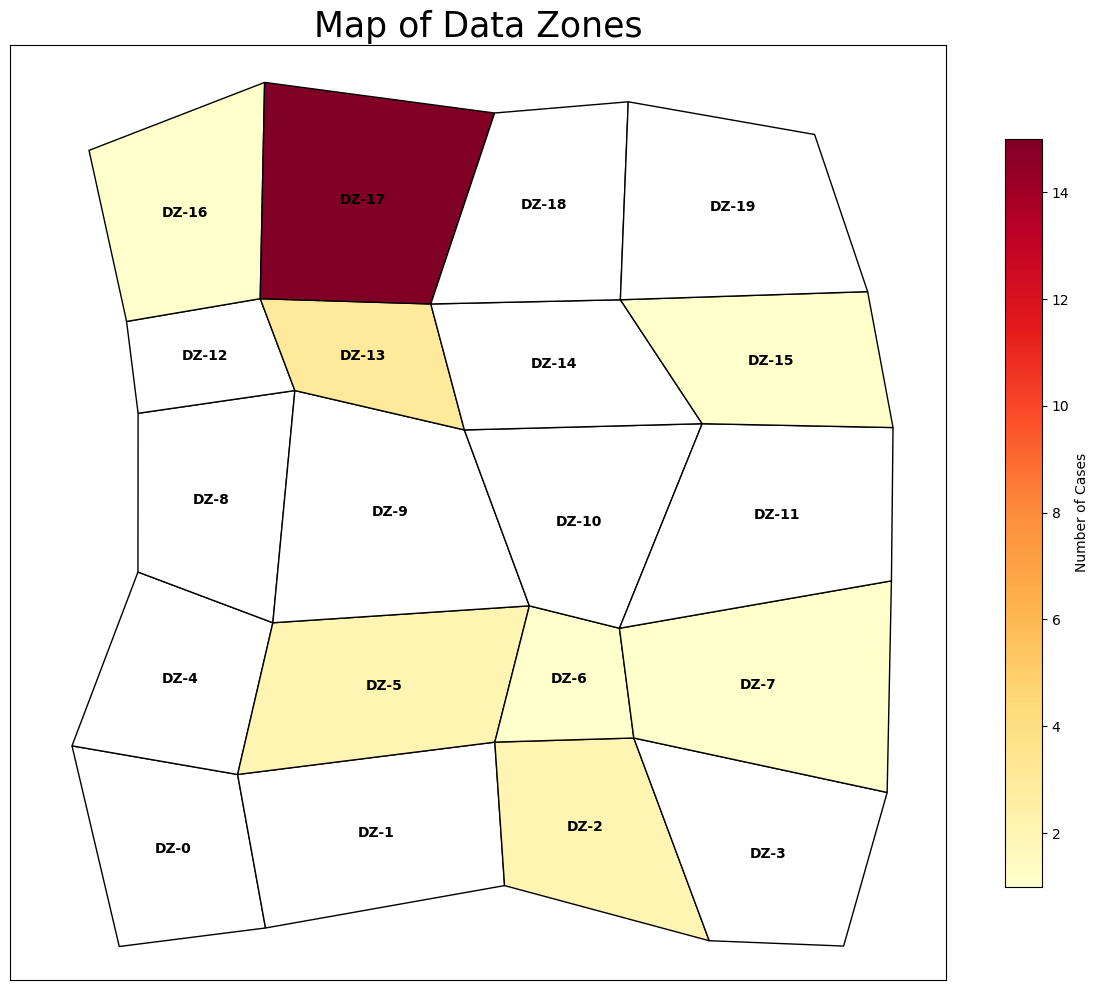

In [82]:
create_DZ_boundaries(available_locations, filename="data_zone_boundaries.png")
create_DZ_boundaries(available_locations, dict(Counter(locations["Data Zone"])), filename="data_zone_boundaries_risk_areas.png")

In [103]:
num_cases = [0, 0, 0, 0, 0, 0, 0, 2, 1, 5, 10, 5, 0, 1, 1, 1]

In [106]:
prevalence = {dz: np.random.choice(num_cases) for dz in locations["Data-Zone"]}

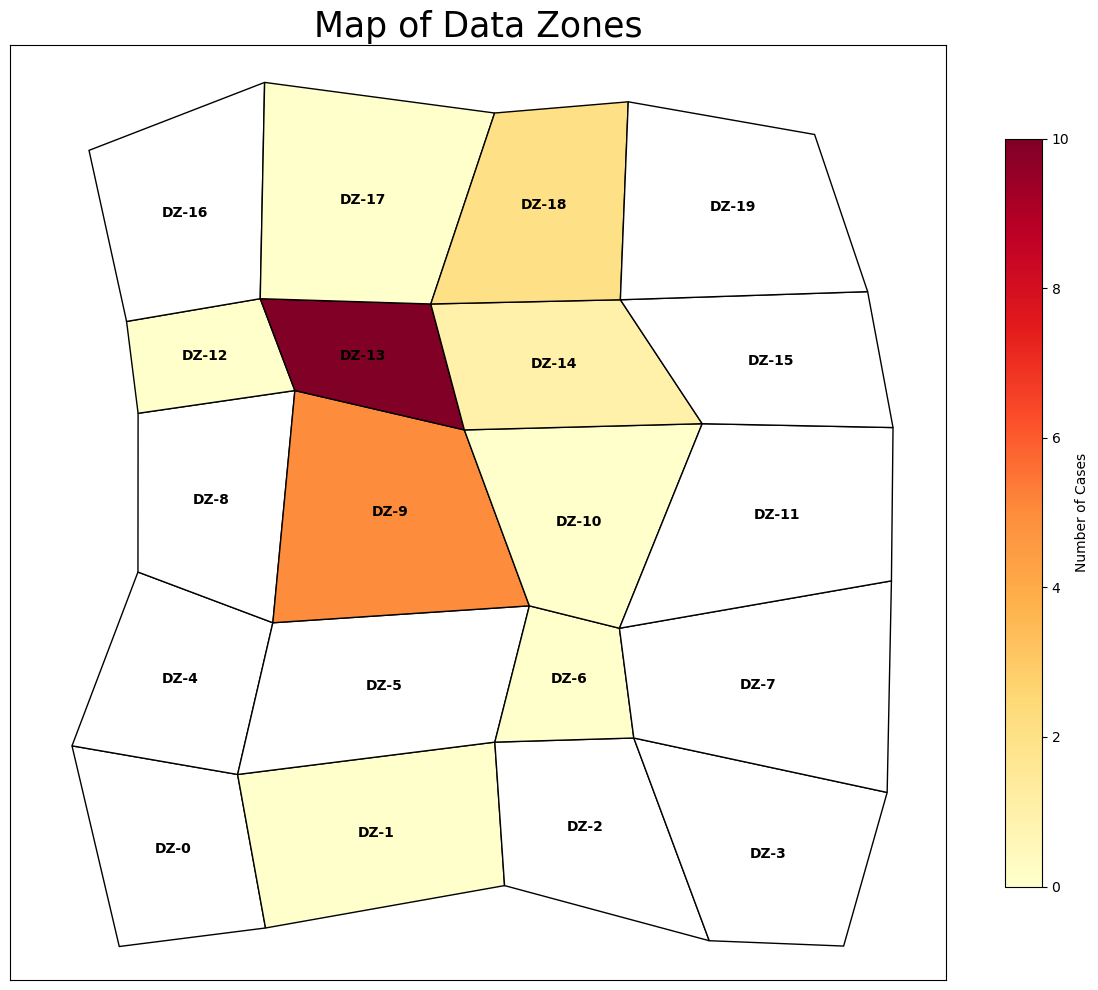

In [107]:
create_DZ_boundaries(available_locations, prevalence, filename="data_zone_boundaries_demo.png")

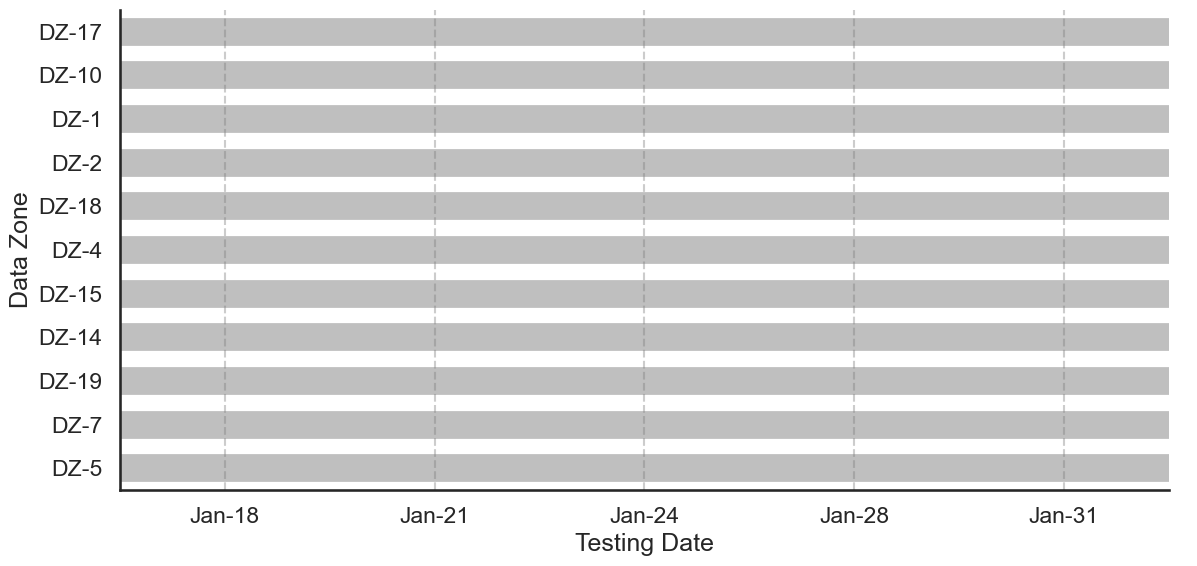

In [181]:
sns.catplot(cases, x="Testing Date", y="Data Zone", height=6, aspect=2, color="red", marker="p", size=10, alpha=0)
plt.grid(True,axis='x', linestyle='--')
plt.grid(True,axis='y', alpha=0.5, linewidth=20, color='grey')
plt.savefig("spatio_temporal_analysis_demo.png", dpi=300, bbox_inches='tight')
plt.show()

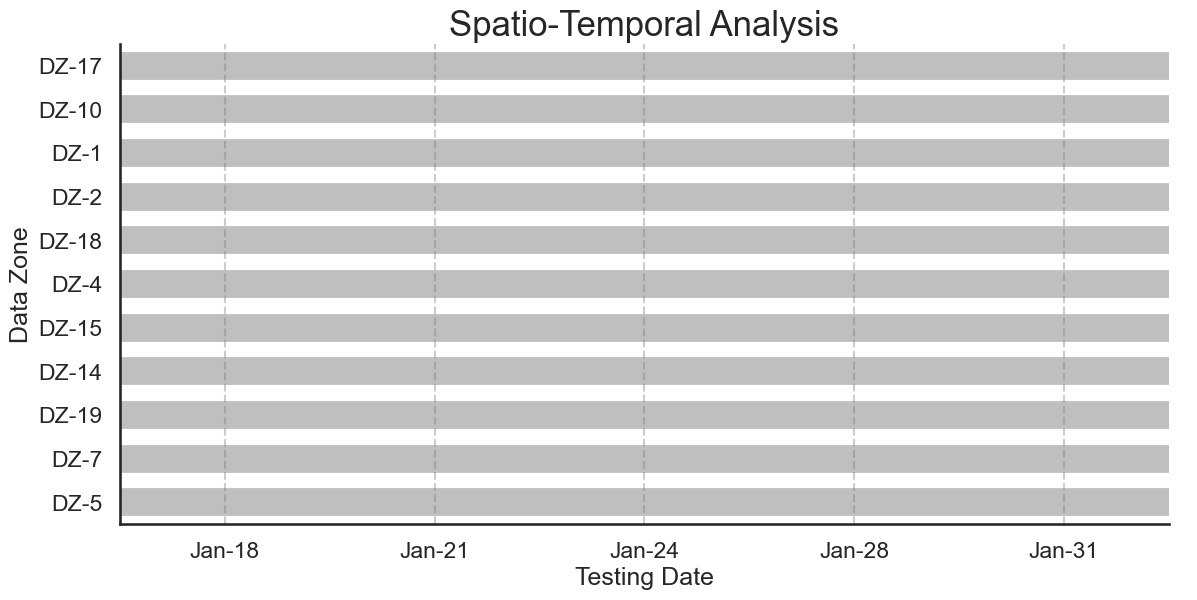

In [186]:
sns.catplot(cases, x="Testing Date", y="Data Zone", height=6, aspect=2, color="red", marker="p", size=10, alpha=0)
plt.grid(True,axis='x', linestyle='--')
plt.grid(True,axis='y', alpha=0.5, linewidth=20, color='grey')
plt.title("Spatio-Temporal Analysis", fontsize=25)
plt.savefig("spatio_temporal_analysis_student_1.png", dpi=300, bbox_inches='tight')
plt.show()

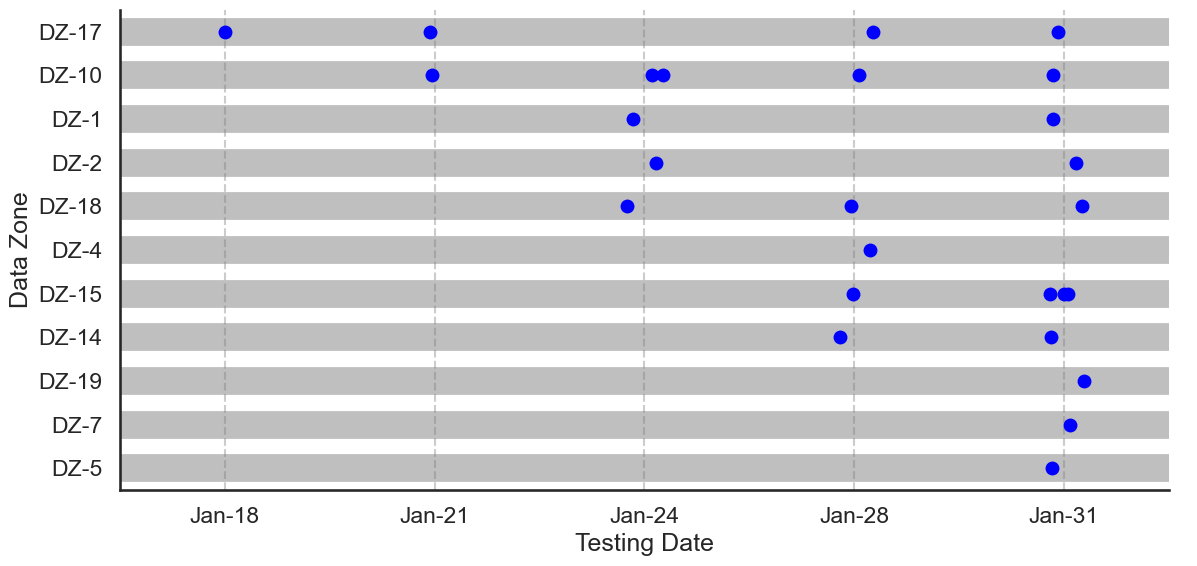

In [187]:
sns.catplot(cases, x="Testing Date", y="Data Zone", height=6, aspect=2, color="blue", size=10)
plt.grid(True,axis='x', linestyle='--')
plt.grid(True,axis='y', alpha=0.5, linewidth=20, color='grey')
plt.title("", fontsize=25)
plt.savefig("spatio_temporal_analysis_1.png", dpi=300, bbox_inches='tight')
plt.show()

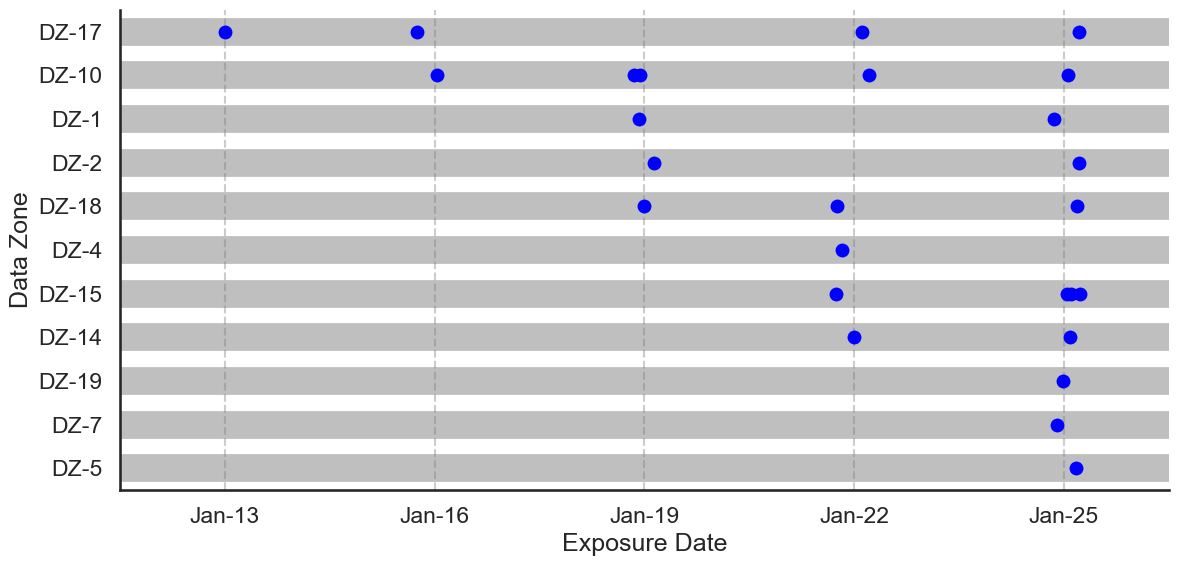

In [191]:
sns.catplot(cases, x="Exposure Date", y="Data Zone", height=6, aspect=2, color="blue", size=10)
plt.grid(True,axis='x', linestyle='--')
plt.grid(True,axis='y', alpha=0.5, linewidth=20, color='grey')
plt.title("", fontsize=25)
plt.savefig("spatio_temporal_analysis_2.png", dpi=300, bbox_inches='tight')
plt.show()

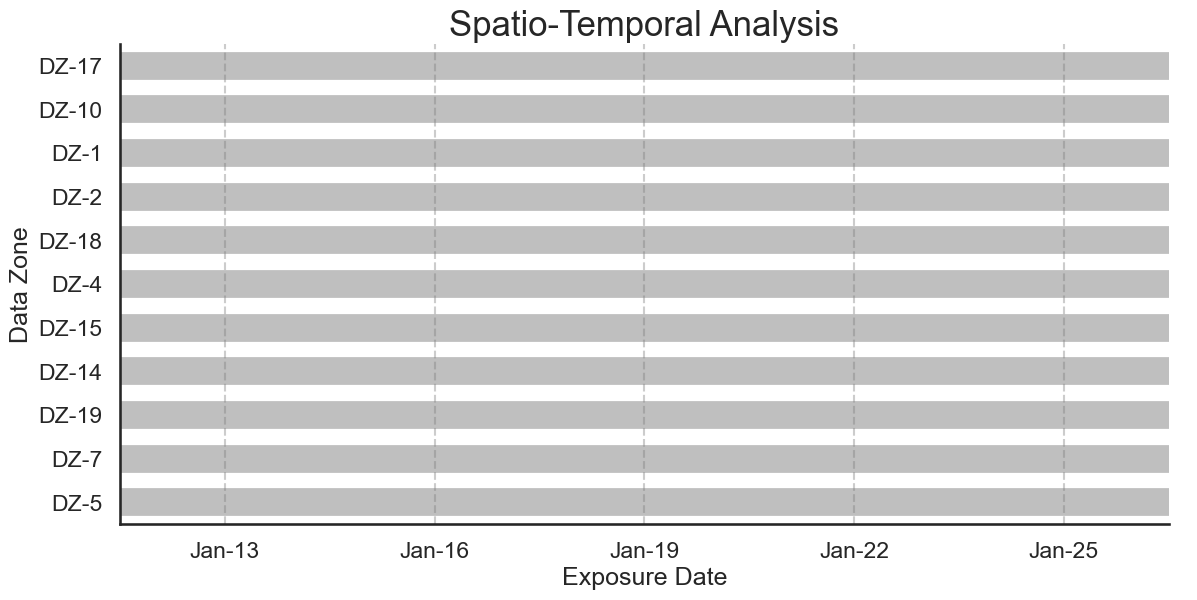

In [185]:
sns.catplot(cases, x="Exposure Date", y="Data Zone", height=6, aspect=2, color="red", marker="p", size=10, alpha=0)
plt.grid(True,axis='x', linestyle='--')
plt.grid(True,axis='y', alpha=0.5, linewidth=20, color='grey')
plt.title("Spatio-Temporal Analysis", fontsize=25)
plt.savefig("spatio_temporal_analysis_student_2.png", dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x600 with 0 Axes>

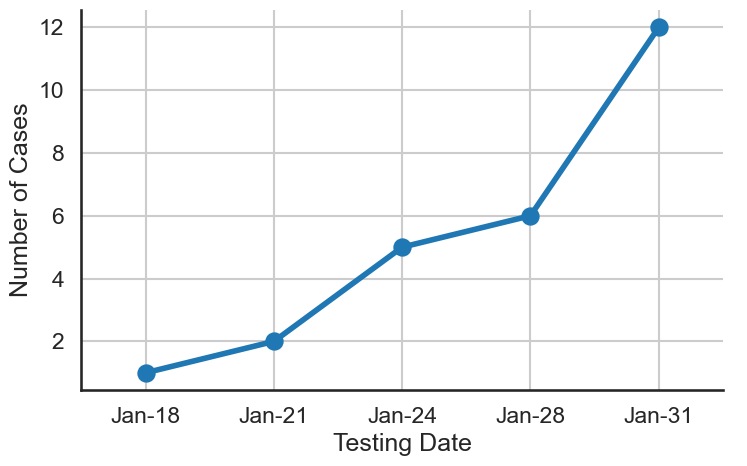

In [193]:
group_cases = cases.groupby("Testing Date").size()

sns.catplot(x=group_cases.index, y=group_cases, kind="point", aspect=1.5)
plt.ylabel("Number of Cases")
plt.grid(True)
plt.savefig("case_count.png", dpi=300, bbox_inches='tight')
plt.show()

In [211]:
def find_intersections(list_of_lists):
    intersections = []
    for i in range(len(list_of_lists)):
        for j in range(i + 1, len(list_of_lists)):
            intersection = set(list_of_lists[i]) & set(list_of_lists[j])
            if intersection:
                intersections.append((i, j, intersection))
    return intersections

# Example usage:
lists = [
    [1, 2, 3],
    [3, 4, 5],
    [6, 7],
    [5, 8, 9]
]

result = find_intersections(cases["Known Contact"].to_list())
print(result[:10])

[(0, 1, {'C-76'}), (0, 2, {'P-23', 'P-3'}), (0, 4, {'P-12'}), (0, 5, {'P-23'}), (0, 10, {'P-23'}), (0, 11, {'P-3'}), (0, 12, {'C-76', 'P-23', 'P-3'}), (0, 16, {'P-5'}), (0, 18, {'P-5'}), (0, 19, {'P-5', 'P-23'})]


In [230]:
seq1="".join(outbreak.result.linearSeqSim[0])
seq2="".join(outbreak.result.linearSeqSim[10])

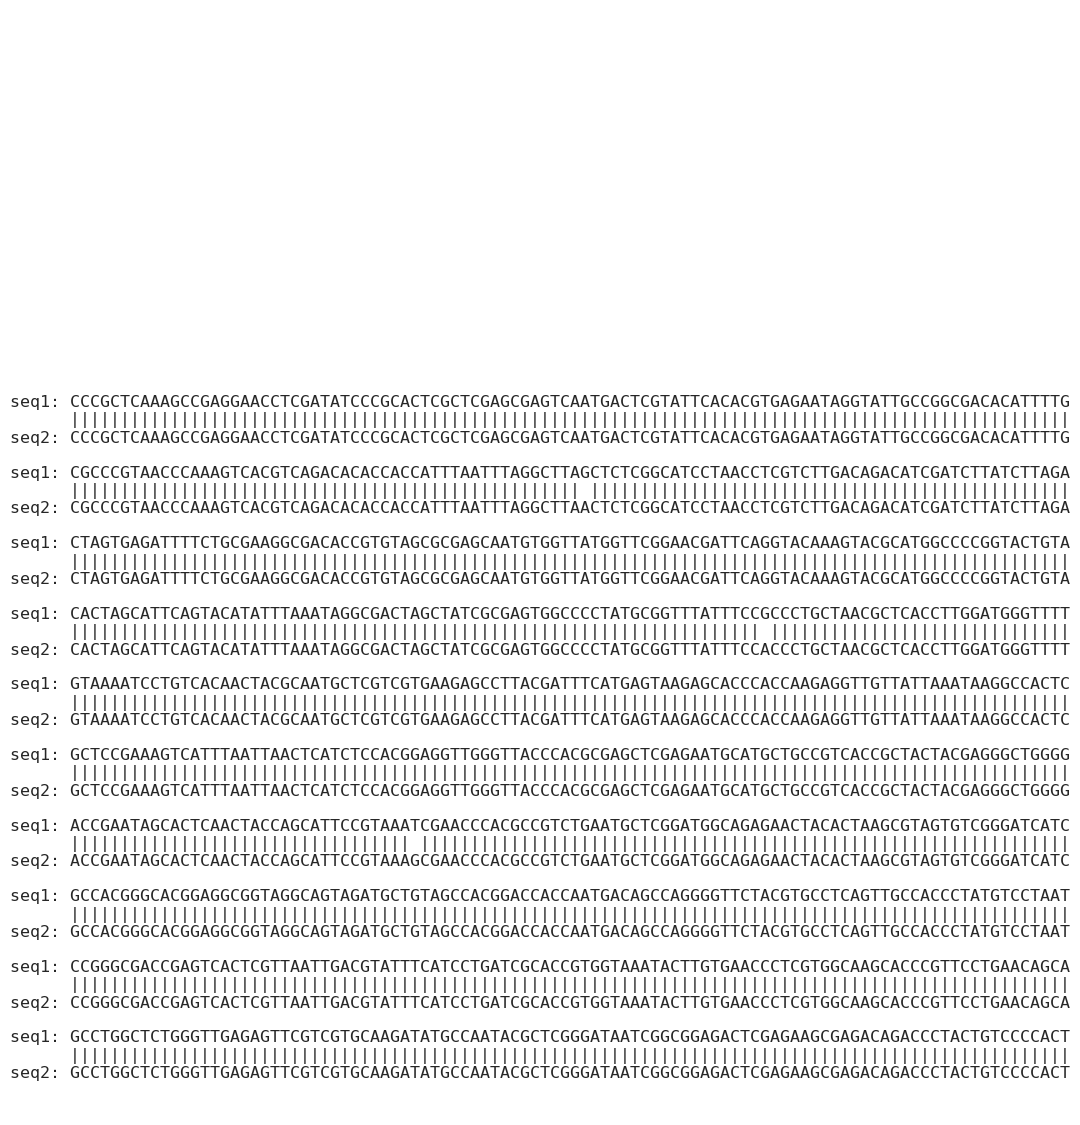

In [231]:
fig, ax = plt.subplots(figsize=(10, 5))
# Hide the axes
ax.axis("off")
ax.text(0, 0, needleman_wunsch.align(seq1, seq2, width=100), fontsize=12, family="monospace", va="top")
plt.savefig("alignment_visualization.png", dpi=300, bbox_inches='tight')
plt.show()